In [3]:
from nuscenes.nuscenes import NuScenes
import numpy as np
import os
#os.chdir('/mnt/ssd2/Introspect3D')
import open3d as o3d
from pprint import pprint
from glob import glob
from mmdet3d.apis import inference_detector, init_model
from math import cos,sin
import matplotlib.pyplot as plt
from nuscenes.utils.data_classes import LidarPointCloud,Box
from nuscenes.nuscenes import NuScenes
import math
from mmdet3d.evaluation.metrics.nuscenes_metric import NuScenesMetric
from mmdet3d.datasets import NuScenesDataset
from mmdet3d.structures import Det3DDataSample, LiDARInstance3DBoxes
from mmdet3d.visualization import Det3DLocalVisualizer
from mmdet3d.structures import LiDARInstance3DBoxes
from pyquaternion import Quaternion
from open3d import geometry
import cv2
import sys
sys.path.append('../')
from utils.boundingbox import BoundingBox
import pickle
from utils.visualizer import Visualizer
from datasets.nuscenes import NuScenesDataset
import imageio
import os
dataroot = '/media/ssd_reza/nuscenes'
%matplotlib inline



Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/wmg-5gcat/Desktop/Sajjad/DistEstIntrospection/mmdetection3d/mmdet3d/evaluation/functional/kitti_utils/eval.py:10: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def get_thresholds(scores: np.ndarray, num_gt, num_sample_pts=41):


In [4]:
import pandas as pd
import numpy as np
# read from csv file
df = pd.read_csv('/media/ssd_reza/sajjad/distest/custom_dataset/nus_centerpoint_early_activations/lv_dist_est2.csv')

In [ ]:
import os
a = 'samples/LIDAR_TOP/n015-2018-07-18-11-07-57+0800__LIDAR_TOP__1531883530449377.pcd.bin'
b = '/media/ssd_reza/nuscenes/'
c = os.path.join(b,a.split('.pcd.bin')[0])

In [7]:
a = np.fromstring(df['gt_lead'][0], dtype=float, sep=' ')
print(len(a))

0


/tmp/ipykernel_3720228/2355302523.py:1: DeprecationWarning: string or file could not be read to its end due to unmatched data; this will raise a ValueError in the future.
  a = np.fromstring(df['gt_lead'][0], dtype=float, sep=' ')


In [16]:
scene_dicts = pickle.load(open('../outputs/lv_scene_dicts.pkl','rb'))
scene = scene_dicts[0]

In [19]:
ego_pose = scene['sensor_calib']
print(ego_pose)

{'token': 'a183049901c24361a6b0b11b8013137c', 'sensor_token': 'dc8b396651c05aedbb9cdaae573bb567', 'translation': [0.943713, 0.0, 1.84023], 'rotation': [0.7077955119163518, -0.006492242056004365, 0.010646214713995808, -0.7063073142877817], 'camera_intrinsic': []}


In [5]:
print(scene.keys())
print(scene['sensor_calib'])
ego_poses = scene['ego_pose']
ego_xy = np.array(ego_poses)[:,0:2]
# reload imported modules
import importlib
import utils.utils
importlib.reload(utils.utils)

from utils.utils import cart2frenet
frenet_xy = cart2frenet(ego_xy,ego_xy)


dict_keys(['scene_token', 'sensor_calib', 'ego_pose', 'ego_rot', 'lidar_files', 'gt_boxes', 'pred_boxes'])
{'token': 'a183049901c24361a6b0b11b8013137c', 'sensor_token': 'dc8b396651c05aedbb9cdaae573bb567', 'translation': [0.943713, 0.0, 1.84023], 'rotation': [0.7077955119163518, -0.006492242056004365, 0.010646214713995808, -0.7063073142877817], 'camera_intrinsic': []}
torch_geometric not installed
torch_geometric not installed


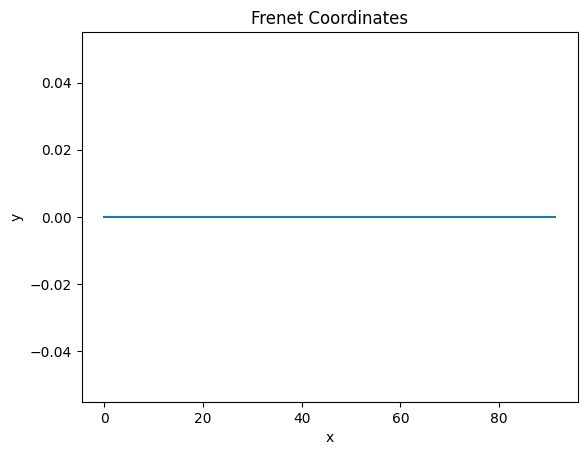

In [6]:
# plot frenet_xy
plt.plot(frenet_xy[:,0],frenet_xy[:,1])
plt.xlabel('x')
plt.ylabel('y')
plt.title('Frenet Coordinates')
plt.show()

In [13]:
sensor_t = scene['sensor_calib']['translation']
sensor_r = scene['sensor_calib']['rotation']
gt_boxes = np.array(scene['gt_boxes'][0][0].center)
print(gt_boxes)
quaternion = Quaternion(sensor_r)
sensor_r = quaternion.rotation_matrix
gt_boxes_global = np.dot(sensor_r,gt_boxes.T).T + sensor_t
print(gt_boxes_global)


[18.414385   59.51602513  0.76963457]
[ 60.49822359 -18.28904132   1.05895171]


In [16]:
gt_boxes = scene['gt_boxes']

box = gt_boxes[0][0].center
print(box)
box_ego_frame = np.dot(sensor_r,box)
print(box_ego_frame)

[18.414385   59.51602513  0.76963457]
[ 59.55451059 -18.28904132  -0.78127829]


In [13]:
a = np.array([1.,2.])
t = np.array([1.,1.])
b = np.array([1.,0.])
rot_mat = np.array([[cos(math.pi/2),-sin(math.pi/2)],[sin(math.pi/2),cos(math.pi/2)]])
print(np.matmul(rot_mat,b)+ t) 

[1. 2.]


In [15]:
ego_translation = scene['ego_pose'][0]
print(ego_translation)

[411.3039349319818, 1180.8903791765097, 0.0]


In [3]:

nusc = NuScenes(version='v1.0-mini', dataroot='/media/ssd_reza/nuscenes/v1.0-mini', verbose=True)


Loading NuScenes tables for version v1.0-mini...
23 category,
8 attribute,
4 visibility,
911 instance,
12 sensor,
120 calibrated_sensor,
31206 ego_pose,
8 log,
10 scene,
404 sample,
31206 sample_data,
18538 sample_annotation,
4 map,
Done loading in 0.822 seconds.
Reverse indexing ...
Done reverse indexing in 0.1 seconds.


In [4]:
scene0 = nusc.scene[0]
sampletoken = scene0['first_sample_token']
sample = nusc.get('sample', sampletoken)
lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
_, boxes, _ = nusc.get_sample_data(lidar['token'])
box = boxes[0]
print('BOX POS (sensor frame): ',box.center)
#print(box.token)
#print(box.token in sample['anns'])
annotation = nusc.get('sample_annotation', box.token)
ego_pose = nusc.get('ego_pose',lidar['ego_pose_token'])
print('EGO POS:',ego_pose['translation'])

print('OBJ POS: ', annotation['translation'])
calibrated_sensor = nusc.get('calibrated_sensor',lidar['calibrated_sensor_token'])
sensor_t = calibrated_sensor['translation']
sensor_r = calibrated_sensor['rotation']
quaternion = Quaternion(sensor_r)
sensor_r = quaternion.rotation_matrix
sensor_t = np.array(sensor_t)
box_in_ego_frame = np.dot(sensor_r, box.center) + sensor_t
ego_r = ego_pose['rotation']
ego_r = Quaternion(ego_r).rotation_matrix
box_in_global_frame = np.dot(ego_r,box_in_ego_frame) + ego_pose['translation']
print(box_in_global_frame)

BOX POS (sensor frame):  [18.414385   59.51602513  0.76963457]
EGO POS: [411.3039349319818, 1180.8903791765097, 0.0]
OBJ POS:  [373.256, 1130.419, 0.8]
[3.732560e+02 1.130419e+03 8.000000e-01]


In [59]:
from pyquaternion import Quaternion

sampletoken = nusc.scene[0]['first_sample_token']
poses = []
rotations = []
while True:
    sample = nusc.get('sample', sampletoken)
    lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    calib = nusc.get('calibrated_sensor',lidar['calibrated_sensor_token'])
    print(calib)
    lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
    ego_pose = nusc.get('ego_pose', lidar['ego_pose_token'])
    quat = Quaternion(ego_pose['rotation'])
    poses.append(ego_pose['translation'])
    rotations.append(quat.rotation_matrix)
    if sample['next'] == "":
        break
    sampletoken = sample['next']
poses = np.array(poses)
rotations = np.array(rotations)
# extend the last pose for another 50 meters
last_pose = poses[-1]
last_pose = last_pose + 50*(last_pose - poses[-2])/np.linalg.norm(last_pose - poses[-2])
distances = []
for i in range(len(poses) - 1):
    distance = np.linalg.norm(poses[i+1] - poses[i])
    distances.append(distance)
distances = np.cumsum(distances)


{'token': 'a183049901c24361a6b0b11b8013137c', 'sensor_token': 'dc8b396651c05aedbb9cdaae573bb567', 'translation': [0.943713, 0.0, 1.84023], 'rotation': [0.7077955119163518, -0.006492242056004365, 0.010646214713995808, -0.7063073142877817], 'camera_intrinsic': []}
{'token': 'a183049901c24361a6b0b11b8013137c', 'sensor_token': 'dc8b396651c05aedbb9cdaae573bb567', 'translation': [0.943713, 0.0, 1.84023], 'rotation': [0.7077955119163518, -0.006492242056004365, 0.010646214713995808, -0.7063073142877817], 'camera_intrinsic': []}
{'token': 'a183049901c24361a6b0b11b8013137c', 'sensor_token': 'dc8b396651c05aedbb9cdaae573bb567', 'translation': [0.943713, 0.0, 1.84023], 'rotation': [0.7077955119163518, -0.006492242056004365, 0.010646214713995808, -0.7063073142877817], 'camera_intrinsic': []}
{'token': 'a183049901c24361a6b0b11b8013137c', 'sensor_token': 'dc8b396651c05aedbb9cdaae573bb567', 'translation': [0.943713, 0.0, 1.84023], 'rotation': [0.7077955119163518, -0.006492242056004365, 0.01064621471399

In [60]:
sample = nusc.get('sample', sampletoken)
lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
lidar_data = nusc.get_sample_data(sample['data']['LIDAR_TOP'])
calib = nusc.get('calibrated_sensor',lidar['calibrated_sensor_token'])
lidar['filename']

'samples/LIDAR_TOP/n015-2018-07-24-11-22-45+0800__LIDAR_TOP__1532402946797517.pcd.bin'

In [44]:
sample = nusc.get('sample', sampletoken)
anns = [nusc.get('sample_annotation', token) for token in sample['anns']]
print([anns[i]['translation'] for i in range(len(anns))])
#print(poses)

[[1002.103, 632.054, 1.836], [925.122, 687.028, 0.606], [918.858, 675.291, 3.248], [926.664, 685.536, 0.53], [967.395, 651.787, 1.675], [947.561, 669.179, 1.566], [994.043, 638.81, 1.58], [933.086, 702.171, 1.119], [923.485, 687.111, 0.72], [921.733, 684.061, 1.416]]


In [49]:
lidar_token = sample['data']['LIDAR_TOP']
_, boxes, _ = nusc.get_sample_data(lidar_token)
print(boxes[1])

label: nan, score: nan, xyz: [-2.10, 10.82, -1.14], wlh: [0.34, 0.40, 0.71], rot axis: [0.01, 0.01, -1.00], ang(degrees): -151.02, ang(rad): -2.64, vel: nan, nan, nan, name: movable_object.trafficcone, token: bafba98de8e145e58a6f0ccb8f23159f


In [23]:
ego_poses = scene['ego_pose']
ego_xy = np.array(ego_poses)[:,0:2]
ego_sd = cart2frenet(ego_xy, ego_xy)
ego_sd_ext = np.concatenate((np.arange(1,52,1).reshape(-1,1),np.zeros((51,1))),axis=1)
print(ego_sd.shape)
ego_sd = np.concatenate((ego_sd,ego_sd_ext),axis=0)
print(ego_sd.shape)


(39, 2)
(90, 2)


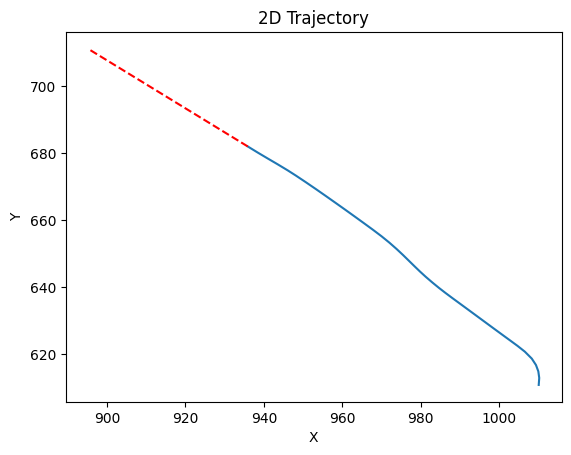

In [10]:
import matplotlib.pyplot as plt

# Plot the 2D trajectory
plt.plot(poses[:, 0], poses[:, 1])
#plot parallel lines with +- 1.5m distance
x_axis = np.array([1, 0, 0])
#plt.plot(poses[-1, 0], poses[-1, 1], 'ro')
x_ext = np.linspace(0, 50, 50)
x = np.dot(rotations[-1], x_axis)
pos_ext = x_ext[:, np.newaxis] * x
pos_ext = pos_ext + poses[-1]
poses = np.concatenate([poses, pos_ext], axis=0)
rotations = np.concatenate([rotations, np.tile(rotations[-1], (50, 1, 1))], axis=0)
plt.plot(pos_ext[:, 0], pos_ext[:, 1], 'r--')

plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Trajectory')
plt.show()


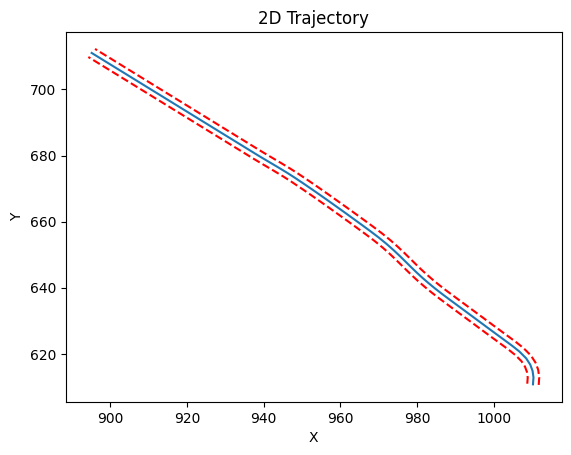

In [12]:
y_axis = np.array([0, 1, 0])
y = [np.dot(rotations[i], y_axis) for i in range(len(rotations))]
y = np.array(y)
upper_bound = poses + 1.5*y
lower_bound = poses - 1.5*y
plt.plot(upper_bound[:, 0], upper_bound[:, 1], 'r--')
plt.plot(lower_bound[:, 0], lower_bound[:, 1], 'r--')
plt.plot(poses[:, 0], poses[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('2D Trajectory')
plt.show()


In [16]:
print(np.nonzero(distances>50)[0][0]-1)
print(distances[19])

19
48.86652022003708


In [30]:
total_distance = [] 
missed_fr_count = 0
all_fr_count = 0
for scene in nusc.scene:
    sampletoken = scene['first_sample_token']
    #print(sampletoken)
    poses = []
    while True:
        sample = nusc.get('sample', sampletoken)
        lidar = nusc.get('sample_data', sample['data']['LIDAR_TOP'])
        ego_pose = nusc.get('ego_pose', lidar['ego_pose_token'])
        poses.append(ego_pose['translation'])
        if sample['next'] == "":
            break
        sampletoken = sample['next']
    poses = np.array(poses)
    # extend the last pose for another 50 meters
    last_pose = poses[-1]
    last_pose = last_pose + 50*(last_pose - poses[-2])/np.linalg.norm(last_pose - poses[-2])
    distances = []
    for i in range(len(poses) - 1):
        distance = np.linalg.norm(poses[i+1] - poses[i])
        distances.append(distance)
    distances = np.cumsum(distances)
    if len(np.nonzero(distances>30)[0]) == 0:
        missed_fr_count += len(distances)
    else:
        missed_fr_count += np.nonzero(distances>30)[0][0]
    all_fr_count += len(distances)

    total_distance.append(distances[-1])
    #print(poses)
print(missed_fr_count/all_fr_count)

0.4247875311570918


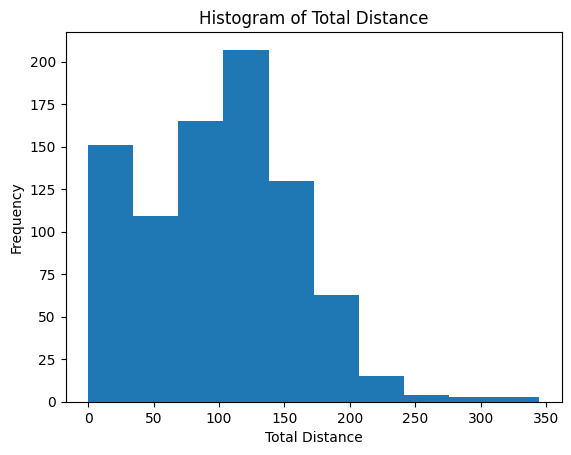

In [27]:
import matplotlib.pyplot as plt

# Plot the histogram
plt.hist(total_distance, bins=10)
plt.xlabel('Total Distance')
plt.ylabel('Frequency')
plt.title('Histogram of Total Distance')
plt.show()


In [23]:
import numpy as np
poses = np.array(poses)
distances = []
for i in range(len(poses) - 1):
    distance = np.linalg.norm(poses[i+1] - poses[i])
    distances.append(distance)

total_distance = np.sum(distances)
print("Total traveled distance:", total_distance)
print(distances)


Total traveled distance: 104.66609098249272
[2.089998818051845, 1.9749264533302606, 1.9944323647478222, 2.181481528092375, 2.7212825145014583, 2.5697283567639, 2.2046982456075677, 2.809632977313436, 2.9501446100298225, 2.9660435197979345, 2.929943306559185, 2.830907156993779, 2.6603447934703004, 2.346048445087145, 2.471774332703026, 2.2645532928878738, 2.3662548195320103, 2.432706016796004, 2.030730515364619, 2.0708881524067198, 2.2194600135227245, 2.334061516802525, 2.436036398979105, 2.630470673465264, 2.8063998136124373, 2.9205514404636204, 3.073878727002141, 3.124843991631918, 3.191301494929083, 3.216207576641731, 3.1716189307420892, 3.164007526067759, 3.2581824666386323, 3.2487852528653973, 2.54340158202494, 3.119009719898325, 3.105932848167311, 3.082611249114119, 3.1528095398865097]


In [135]:
rainy_scenes = []
for scene in nusc.scene:
    if 'rain' in scene['description'].lower():
        rainy_scenes.append(scene['token'])
        #print(scene['name'] + ':' + scene['description'])
print("Rainy scenes:{}, out of: {}".format(len(rainy_scenes), len(nusc.scene)))

Rainy scenes:165, out of: 850


In [136]:
rainy_samples = []
all_samples = nusc.sample
for sample in all_samples:
    if sample['scene_token'] in rainy_scenes:
        rainy_samples.append(sample['token'])
print("Rainy samples:{}, out of: {}".format(len(rainy_samples), len(all_samples)))

Rainy samples:6670, out of: 34149


In [153]:
# load .csv file
import pandas as pd
data = pd.read_csv('test2.csv')
sample_tokens = data['sample_records']
dist_error = np.sqrt(np.power(data['error_lat'],2) + np.power(data['error_long'],2))
lon_error = data['error_long']
#ind = np.nonzero(long_error==100)[0][0]
#print(data['gt_lead'][ind], data['pred_lead'][ind])
false_positive = np.logical_and(data['gt_lead']==False, data['pred_lead']==True)
false_negative = np.logical_and(data['gt_lead']==True, data['pred_lead']==False)
true_negative = np.logical_and(data['gt_lead']==False, data['pred_lead']==False)
true_positive = np.logical_and(data['gt_lead']==True, data['pred_lead']==True)
tp_samples = sample_tokens[true_positive]
tp_lon_error = lon_error[true_positive]
n_samples = len(true_positive)
n_tp = np.sum(true_positive)
n_fp = np.sum(false_positive)
n_tn = np.sum(true_negative)
n_fn = np.sum(false_negative)
print(f'Total Samples: {n_samples},\n \
True Positive: {n_tp} ({n_tp/n_samples*100:.2f}%),\n \
False Positive: {n_fp} ({n_fp/n_samples*100:.2f}%),\n \
True Negative: {n_tn} ({n_tn/n_samples*100:.2f}%),\n \
False Negative: {n_fn} ({n_fn/n_samples*100:.2f}%)'
      )
print('TP only: Mean Longitude Error: {}, Median Longitude Error: {}'.format(np.mean(tp_lon_error), np.median(tp_lon_error)))

Total Samples: 34148,
 True Positive: 8646 (25.32%),
 False Positive: 888 (2.60%),
 True Negative: 18268 (53.50%),
 False Negative: 6346 (18.58%)
TP only: Mean Longitude Error: 1.3768580191681163, Median Longitude Error: 0.13427740919798214


In [154]:
# select rainy samples in data:
rainy_indx = sample_tokens.isin(rainy_samples)
rainy_indx = rainy_indx.values
rainy_tokens = sample_tokens[rainy_indx].values
rainy_lon_error= lon_error[rainy_indx].values
rainy_fp = false_positive[rainy_indx].values
rainy_fn = false_negative[rainy_indx].values
rainy_tp = true_positive[rainy_indx].values
rainy_tn = true_negative[rainy_indx].values
rainy_tp_samples = rainy_tokens[rainy_tp]
rainy_tp_lon_error = rainy_lon_error[rainy_tp]
n_samples = len(rainy_tp)
n_tp = np.sum(rainy_tp)
n_fp = np.sum(rainy_fp)
n_tn = np.sum(rainy_tn)
n_fn = np.sum(rainy_fn)
print(f'Total Rainy Samples: {n_samples},\n \
True Positive: {n_tp} ({n_tp/n_samples*100:.2f}%),\n \
False Positive: {n_fp} ({n_fp/n_samples*100:.2f}%),\n \
True Negative: {n_tn} ({n_tn/n_samples*100:.2f}%),\n \
False Negative: {n_fn} ({n_fn/n_samples*100:.2f}%)'
      )
print('TP only:Mean Longitude Error: {}, Median Longitude Error: {}'.format(np.mean(rainy_tp_lon_error), np.median(rainy_tp_lon_error)))

Total Rainy Samples: 6669,
 True Positive: 1421 (21.31%),
 False Positive: 174 (2.61%),
 True Negative: 3564 (53.44%),
 False Negative: 1510 (22.64%)
TP only:Mean Longitude Error: 0.9556518516559753, Median Longitude Error: 0.1372144172472715


In [155]:
# select rainy samples in data:
not_rainy_indx = ~sample_tokens.isin(rainy_samples)
not_rainy_indx = not_rainy_indx.values
not_rainy_tokens = sample_tokens[not_rainy_indx].values
not_rainy_lon_error= lon_error[not_rainy_indx].values
not_rainy_fp = false_positive[not_rainy_indx].values
not_rainy_fn = false_negative[not_rainy_indx].values
not_rainy_tp = true_positive[not_rainy_indx].values
not_rainy_tn = true_negative[not_rainy_indx].values
not_rainy_tp_samples = not_rainy_tokens[not_rainy_tp]
not_rainy_tp_lon_error = not_rainy_lon_error[not_rainy_tp]
n_samples = len(not_rainy_tp)
n_tp = np.sum(not_rainy_tp)
n_fp = np.sum(not_rainy_fp)
n_tn = np.sum(not_rainy_tn)
n_fn = np.sum(not_rainy_fn)
print(f'Total Non Rainy Samples: {n_samples},\n \
True Positive: {n_tp} ({n_tp/n_samples*100:.2f}%),\n \
False Positive: {n_fp} ({n_fp/n_samples*100:.2f}%),\n \
True Negative: {n_tn} ({n_tn/n_samples*100:.2f}%),\n \
False Negative: {n_fn} ({n_fn/n_samples*100:.2f}%)'
      )
print('TP only: Mean Longitude Error: {}, Median Longitude Error: {}'.format(np.mean(not_rainy_tp_lon_error), np.median(not_rainy_tp_lon_error)))

Total Non Rainy Samples: 27479,
 True Positive: 7225 (26.29%),
 False Positive: 714 (2.60%),
 True Negative: 14704 (53.51%),
 False Negative: 4836 (17.60%)
TP only: Mean Longitude Error: 1.4597000903147948, Median Longitude Error: 0.1336733185629075


In [162]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.offline import init_notebook_mode, iplot
from plotly.subplots import make_subplots
init_notebook_mode(connected=True)         # initiate notebook for offline plot

#plot ecdf
fig = px.ecdf(tp_lon_error, title='Longitude Error ECDF')
# add rainy samples ecdf
# update axis labels
fig.update_xaxes(title_text='Longitude Error (m)')
fig.update_yaxes(title_text='Cumulative Distribution')
fig.show()
fig.write_html('tp_lon_error.html')



In [44]:

#print(len(nusc.scene), len(nusc.sample))
#print(nusc.sample[0])
#print(nusc.scene[0])
#print(nusc.get('scene',(nusc.get('sample',nusc.sample[0]['token'])['scene_token'])))
rainy_scenes = []
for scene in nusc.scene:
    if 'rain' in scene['description'].lower():
        rainy_scenes.append(scene['name'])
        #print(scene['name'] + ':' + scene['description'])
print(len(rainy_scenes))

165


In [14]:

n_samples = []
for scene in nusc.scene:
    n_samples.append(scene['nbr_samples'])
print('min:{}, mean:{}, max:{}'.format(min(n_samples),np.mean(n_samples),max(n_samples)))

min:32, mean:40.175294117647056, max:41


In [15]:
token = nusc.sample[0]['token']
sample = nusc.get('sample',token)
all_samples = [sample]
cur_sample = sample
while cur_sample['prev'] != '':
    cur_sample = nusc.get('sample',cur_sample['prev'])
    # append at the begining of the list
    all_samples.insert(0,cur_sample)
cur_sample = sample
while cur_sample['next'] != '':
    cur_sample = nusc.get('sample',cur_sample['next'])
    all_samples.append(cur_sample)
seq_len = len(all_samples)
print('total samples:', seq_len)



total samples: 40


In [16]:
from typing import Union
from enum import Enum
class Colors(Enum):
    RED = (1,0,0)
    GREEN = (0,1,0)
    BLUE = (0,0,1)
    YELLOW = (1,1,0)
    CYAN = (0,1,1)
    MAGENTA = (1,0,1)
    WHITE = (1,1,1)
    BLACK = (0,0,0)
    ORANGE = (1,0.5,0)
    PURPLE = (0.5,0,1)
    PINK = (1,0,0.5)
def create_line_set_bounding_box(box: BoundingBox,
                                offset:Union[float, np.ndarray],
                                axis:Union[int, np.ndarray],
                                color:Union[tuple, np.ndarray] = Colors.BLUE) -> o3d.geometry.LineSet:

    if box.corners.shape[0] != 8:
        temp_corners = box.corners.T
    else:
        temp_corners = box.corners
    o3d_box = o3d.geometry.OrientedBoundingBox.create_from_points(o3d.utility.Vector3dVector(temp_corners))

        

    o3d_box.color = color
    line_set = o3d.geometry.LineSet.create_from_oriented_bounding_box(o3d_box)
    return line_set


In [ ]:
sample = all_samples[0]

# get bounding boxes
annotations = [nusc.get('sample_annotation', token) for token in sample['anns']]
print(annotations[0])

In [ ]:
from tqdm import tqdm
vis = o3d.visualization.Visualizer()

for sample_itr, sample in tqdm(enumerate(all_samples)):
    
    # bounding boxes
    annotations = [nusc.get('sample_annotation', token) for token in sample['anns']]
    gt_bbox = []
    for ann in annotations:
        box = nusc.get_box(ann['token'])
        custom_bbox = BoundingBox()
        custom_bbox.from_nuscenes_box(box)
        gt_bbox.append(custom_bbox)
    # lidar data
    li_file = nusc.get('sample_data',sample['data']['LIDAR_TOP'])['filename']
    li_file = os.path.join(dataroot,li_file)
    lidar_data = LidarPointCloud.from_file(li_file)
    lidar_points = lidar_data.points.T
    lidar_cloud = o3d.geometry.PointCloud()
    lidar_cloud.points = o3d.utility.Vector3dVector(lidar_points[:,:3])
    filename = 'frames/frame_{}.png'.format(str(sample_itr).zfill(2))
    vis.create_window(visible=True)
    for box in gt_bbox:
        vis.add_geometry(create_line_set_bounding_box(box,0,0,Colors.GREEN.value))
    
    vis.add_geometry(lidar_cloud)
    vis.update_geometry(lidar_cloud)
    vis.poll_events()
    vis.update_renderer()
    break

    

In [ ]:
# create gif
images = []
for i in reversed(range(seq_len)):
    filename = 'frames/frame_{}.png'.format(str(i).zfill(2))
    images.append(imageio.imread(filename))
imageio.mimsave('nuscenes.gif', images, duration=0.5)